Topic-Word Distribution:
Topic 1: banana orange apple
Topic 2: apple banana orange

Document-Topic Distribution:
Document 1: [0.32917129 0.67082871]
Document 2: [1. 0.]
Document 3: [0.59951013 0.40048987]
Document 4: [1.20260679e-28 1.00000000e+00]


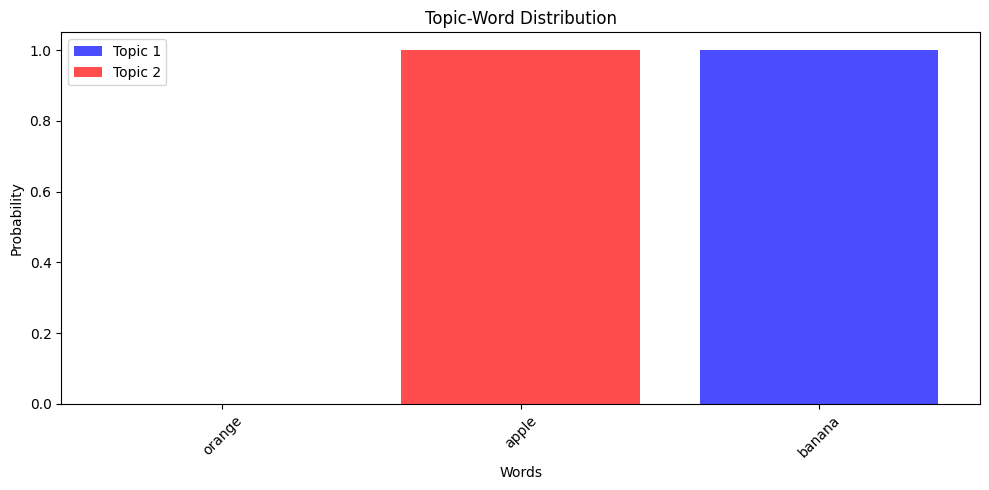

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simple dataset
documents = ["apple banana orange",
             "banana orange banana",
             "orange apple banana",
             "banana apple apple"]

# Preprocessing
# Create vocabulary
vocab = set(word for document in documents for word in document.split())

# Create word to index and index to word mapping
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Create document-term matrix
dt_matrix = np.zeros((len(documents), len(vocab)), dtype=int)
for i, document in enumerate(documents):
    for word in document.split():
        dt_matrix[i, word_to_index[word]] += 1

# LDA implementation
def lda(data_matrix, num_topics, num_iterations=100):
    num_documents, num_words = data_matrix.shape
    np.random.seed(0)  # For reproducibility

    # Initialize parameters
    phi = np.random.rand(num_topics, num_words)
    theta = np.random.rand(num_documents, num_topics)

    # Normalize phi and theta
    phi /= np.sum(phi, axis=1)[:, np.newaxis]
    theta /= np.sum(theta, axis=1)[:, np.newaxis]

    # Iterative optimization
    for _ in range(num_iterations):
        # E-step
        for d in range(num_documents):
            for k in range(num_topics):
                theta[d, k] = np.sum(phi[k, :] * data_matrix[d, :]) * theta[d, k]

        # Normalize theta
        theta /= np.sum(theta, axis=1)[:, np.newaxis]

        # M-step
        for k in range(num_topics):
            for w in range(num_words):
                phi[k, w] = np.sum(theta[:, k] * data_matrix[:, w]) * phi[k, w]

        # Normalize phi
        phi /= np.sum(phi, axis=1)[:, np.newaxis]

    return phi, theta

# Number of topics
num_topics = 2

# Run LDA
phi, theta = lda(dt_matrix, num_topics)

# Visualization
# Display topic-word distribution
print("Topic-Word Distribution:")
for i, topic_dist in enumerate(phi):
    top_words_indices = np.argsort(topic_dist)[::-1][:3]
    top_words = [index_to_word[idx] for idx in top_words_indices]
    print(f"Topic {i+1}: {' '.join(top_words)}")

# Display document-topic distribution
print("\nDocument-Topic Distribution:")
for i, doc_dist in enumerate(theta):
    print(f"Document {i+1}: {doc_dist}")

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(len(vocab)), phi[0], color='blue', alpha=0.7, label='Topic 1')
plt.bar(range(len(vocab)), phi[1], color='red', alpha=0.7, label='Topic 2')
plt.xticks(range(len(vocab)), vocab, rotation=45)
plt.xlabel('Words')
plt.ylabel('Probability')
plt.title('Topic-Word Distribution')
plt.legend()
plt.tight_layout()
plt.show()


Shape of X: (150, 4)
Shape of transformed X: (150, 2)


<ipython-input-2-d0da732a9623>:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)


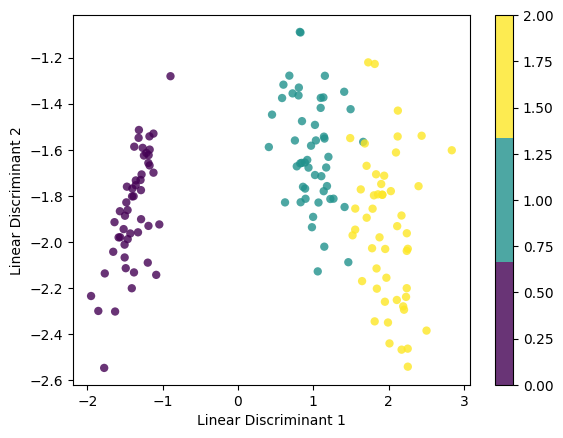

In [ ]:
import numpy as np


class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)


# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

    data = datasets.load_iris()
    X, y = data.data, data.target

    # Project the data onto the 2 primary linear discriminants
    lda = LDA(2)
    lda.fit(X, y)
    X_projected = lda.transform(X)

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1, x2 = X_projected[:, 0], X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.colorbar()
    plt.show()

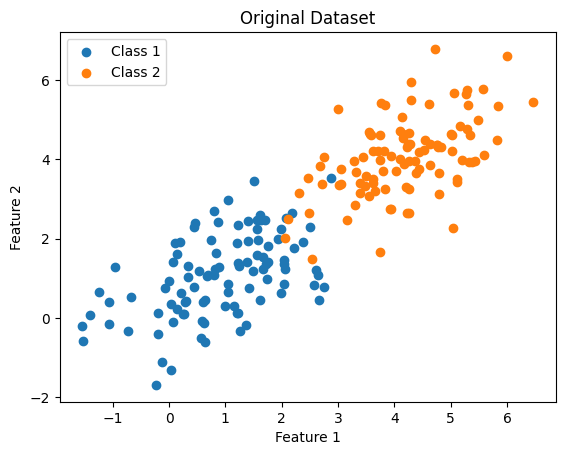

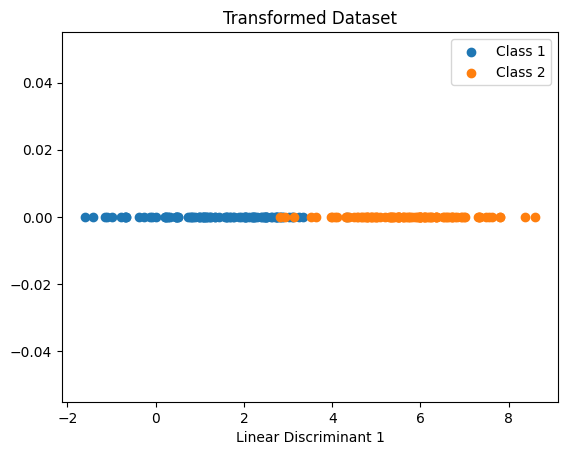

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)

# Create a synthetic dataset
np.random.seed(0)
mean1 = [1, 1]
cov1 = [[1, 0.5], [0.5, 1]]
class1 = np.random.multivariate_normal(mean1, cov1, 100)

mean2 = [4, 4]
cov2 = [[1, 0.5], [0.5, 1]]
class2 = np.random.multivariate_normal(mean2, cov2, 100)

X = np.concatenate((class1, class2))
y = np.concatenate((np.zeros(100), np.ones(100)))

# Visualize the original dataset
plt.scatter(class1[:, 0], class1[:, 1], label='Class 1')
plt.scatter(class2[:, 0], class2[:, 1], label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Dataset')
plt.legend()
plt.show()

# Apply LDA
lda = LDA(1)
lda.fit(X, y)
X_projected = lda.transform(X)

# Visualize the transformed dataset
plt.scatter(X_projected[y == 0], np.zeros((100, 1)), label='Class 1')
plt.scatter(X_projected[y == 1], np.zeros((100, 1)), label='Class 2')
plt.xlabel('Linear Discriminant 1')
plt.title('Transformed Dataset')
plt.legend()
plt.show()


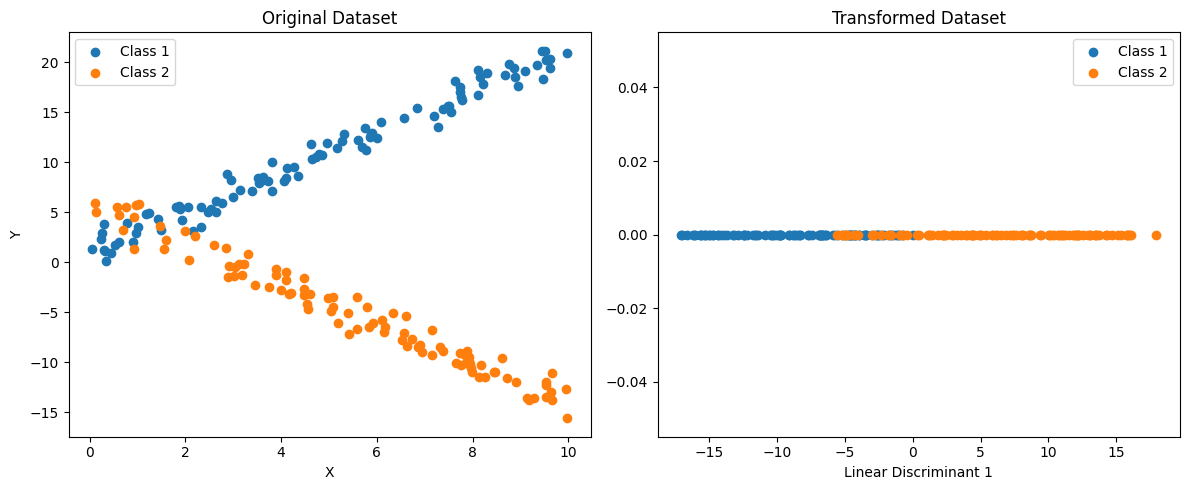

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        A = np.linalg.inv(SW).dot(SB)
        eigenvalues, eigenvectors = np.linalg.eig(A)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        return np.dot(X, self.linear_discriminants.T)

# Synthetic dataset
class1_x = np.random.uniform(0, 10, 100)
class1_y = 2 * class1_x + 1 + np.random.normal(0, 1, 100)

class2_x = np.random.uniform(0, 10, 100)
class2_y = -2 * class2_x + 6 + np.random.normal(0, 1, 100)

X = np.vstack((np.column_stack((class1_x, class1_y)), np.column_stack((class2_x, class2_y))))
y = np.hstack((np.zeros(100), np.ones(100)))

# Plot original data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(class1_x, class1_y, label='Class 1')
plt.scatter(class2_x, class2_y, label='Class 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Dataset')
plt.legend()

# Apply LDA
lda = LDA(1)
lda.fit(X, y)
X_projected = lda.transform(X)

# Visualize the transformed dataset
plt.subplot(1, 2, 2)
plt.scatter(X_projected[y == 0], np.zeros((100, 1)), label='Class 1')
plt.scatter(X_projected[y == 1], np.zeros((100, 1)), label='Class 2')
plt.xlabel('Linear Discriminant 1')
plt.title('Transformed Dataset')
plt.legend()

plt.tight_layout()
plt.show()
